# PROJECT 4 - Fatal Accident Data

In [1]:
# Import required libraries
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import findspark
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from mrjob.job import MRJob
import geopandas as gpd
from pprint import pprint
import warnings
import seaborn as sns
import mplcursors
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
warnings.filterwarnings('ignore')

In [2]:
# Specify file path
file_path = 'C:/Users/mmack/OneDrive/Desktop/Traffic_Collisions_Project4/Mary/accident.csv'

In [3]:
# Specify the columns to import
use_columns = ['STATENAME', 'ST_CASE', 'PEDS', 'VE_TOTAL', 'COUNTYNAME', 'CITYNAME', 'MONTH', 'DAY', 'YEAR', 'HOUR', 'MINUTE', 'TWAY_ID', 'TWAY_ID2', 
               'RUR_URBNAME', 'LATITUDE', 'LONGITUDE', 'HARM_EVNAME', 'WEATHERNAME', 'NOT_HOUR', 'NOT_MIN', 'ARR_HOUR', 'ARR_MIN', 
               'HOSP_HR', 'HOSP_MN', 'FATALS']

# Read the CSV file using Pandas
df = pd.read_csv('C:/Users/mmack/OneDrive/Desktop/Traffic_Collisions_Project4/Mary/accident.csv', encoding='latin1', usecols=use_columns)
df.head()

,STATENAME,ST_CASE,PEDS,VE_TOTAL,COUNTYNAME,CITYNAME,MONTH,DAY,YEAR,HOUR,...,LONGITUDE,HARM_EVNAME,WEATHERNAME,NOT_HOUR,NOT_MIN,ARR_HOUR,ARR_MIN,HOSP_HR,HOSP_MN,FATALS
0,Alabama,10001,0,2,PICKENS (107),NOT APPLICABLE,1,1,2022,12,...,-88.274083,Motor Vehicle In-Transport,Clear,12,47,13,4,13,47,1
1,Alabama,10002,0,2,MONTGOMERY (101),NOT APPLICABLE,1,1,2022,16,...,-86.064153,Motor Vehicle In-Transport,Clear,99,99,99,99,99,99,2
2,Alabama,10003,0,1,ST. CLAIR (115),NOT APPLICABLE,1,1,2022,1,...,-86.351994,Tree (Standing Only),Cloudy,1,33,1,50,99,99,1
3,Alabama,10004,0,1,MONTGOMERY (101),NOT APPLICABLE,1,2,2022,14,...,-86.400169,Ditch,Cloudy,14,48,15,9,15,44,1
4,Alabama,10005,1,1,JEFFERSON (73),NOT APPLICABLE,1,2,2022,18,...,-86.687389,Pedestrian,Rain,18,48,18,54,88,88,1


## CLEAN DF & CREATE NEW & CALCULATED COLUMNS FOR ANALYSIS

In [12]:
# Create ACCIDENT_DATE column
new_df['ACCIDENT_DATE'] = pd.to_datetime(new_df[['YEAR', 'MONTH', 'DAY']])

# Function to validate time values
def validate_time(hour, minute):
    if 0 <= hour < 24 and 0 <= minute < 60:
        return True
    return False

# Merge hour and minute columns into new datetime columns with validation
new_df['NOT_TIME'] = new_df.apply(lambda row: pd.to_datetime(f"{row['YEAR']}-{row['MONTH']}-{row['DAY']} {row['NOT_HOUR']}:{row['NOT_MIN']}")
                                           if validate_time(row['NOT_HOUR'], row['NOT_MIN']) else pd.NaT, axis=1)
new_df['AMBO_ARR_TIME'] = new_df.apply(lambda row: pd.to_datetime(f"{row['YEAR']}-{row['MONTH']}-{row['DAY']} {row['ARR_HOUR']}:{row['ARR_MIN']}")
                                                if validate_time(row['ARR_HOUR'], row['ARR_MIN']) else pd.NaT, axis=1)
new_df['HOSP_ARR_TIME'] = new_df.apply(lambda row: pd.to_datetime(f"{row['YEAR']}-{row['MONTH']}-{row['DAY']} {row['HOSP_HR']}:{row['HOSP_MN']}")
                                                if validate_time(row['HOSP_HR'], row['HOSP_MN']) else pd.NaT, axis=1)

# Replace NaT values with ACCIDENT_DATE and '00:00:00' as the time component
new_df['NOT_TIME'] = new_df['NOT_TIME'].fillna(new_df['ACCIDENT_DATE'].astype(str) + ' 00:00:00')
new_df['AMBO_ARR_TIME'] = new_df['AMBO_ARR_TIME'].fillna(new_df['ACCIDENT_DATE'].astype(str) + ' 00:00:00')
new_df['HOSP_ARR_TIME'] = new_df['HOSP_ARR_TIME'].fillna(new_df['ACCIDENT_DATE'].astype(str) + ' 00:00:00')

# Convert the filled columns back to datetime
new_df['NOT_TIME'] = pd.to_datetime(new_df['NOT_TIME'])
new_df['AMBO_ARR_TIME'] = pd.to_datetime(new_df['AMBO_ARR_TIME'])
new_df['HOSP_ARR_TIME'] = pd.to_datetime(new_df['HOSP_ARR_TIME'])

# Create calculated fields for time differences
new_df['TIME_TO_AMBO'] = (new_df['AMBO_ARR_TIME'] - new_df['NOT_TIME']).dt.total_seconds() / 60  # Time in minutes
new_df['TIME_TO_HOSP'] = (new_df['HOSP_ARR_TIME'] - new_df['AMBO_ARR_TIME']).dt.total_seconds() / 60  # Time in minutes

# display first 5 rows
new_df

,STATENAME,ST_CASE,PEDS,VE_TOTAL,COUNTYNAME,CITYNAME,MONTH,DAY,YEAR,HOUR,...,ARR_MIN,HOSP_HR,HOSP_MN,FATALS,ACCIDENT_DATE,NOT_TIME,AMBO_ARR_TIME,HOSP_ARR_TIME,TIME_TO_AMBO,TIME_TO_HOSP
0,Alabama,10001,0,2,PICKENS (107),NOT APPLICABLE,1,1,2022,12,...,4,13,47,1,2022-01-01,2022-01-01 12:47:00,2022-01-01 13:04:00,2022-01-01 13:47:00,17.0,43.0
1,Alabama,10002,0,2,MONTGOMERY (101),NOT APPLICABLE,1,1,2022,16,...,99,99,99,2,2022-01-01,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,0.0,0.0
2,Alabama,10003,0,1,ST. CLAIR (115),NOT APPLICABLE,1,1,2022,1,...,50,99,99,1,2022-01-01,2022-01-01 01:33:00,2022-01-01 01:50:00,2022-01-01 00:00:00,17.0,-110.0
3,Alabama,10004,0,1,MONTGOMERY (101),NOT APPLICABLE,1,2,2022,14,...,9,15,44,1,2022-01-02,2022-01-02 14:48:00,2022-01-02 15:09:00,2022-01-02 15:44:00,21.0,35.0
4,Alabama,10005,1,1,JEFFERSON (73),NOT APPLICABLE,1,2,2022,18,...,54,88,88,1,2022-01-02,2022-01-02 18:48:00,2022-01-02 18:54:00,2022-01-02 00:00:00,6.0,-1134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39216,Wyoming,560114,0,2,SWEETWATER (37),ROCK SPRINGS,12,27,2022,11,...,35,12,4,1,2022-12-27,2022-12-27 11:30:00,2022-12-27 11:35:00,2022-12-27 12:04:00,5.0,29.0
39217,Wyoming,560115,0,1,LINCOLN (23),NOT APPLICABLE,10,24,2022,7,...,98,88,88,1,2022-10-24,2022-10-24 00:00:00,2022-10-24 00:00:00,2022-10-24 00:00:00,0.0,0.0
39218,Wyoming,560116,0,1,LARAMIE (21),CHEYENNE,12,21,2022,15,...,7,15,27,1,2022-12-21,2022-12-21 15:02:00,2022-12-21 15:07:00,2022-12-21 15:27:00,5.0,20.0
39219,Wyoming,560117,0,1,JOHNSON (19),NOT APPLICABLE,12,22,2022,0,...,40,88,88,1,2022-12-22,2022-12-22 07:24:00,2022-12-22 07:40:00,2022-12-22 00:00:00,16.0,-460.0


In [18]:
new_df = df
new_df.head()

,STATENAME,ST_CASE,PEDS,VE_TOTAL,COUNTYNAME,CITYNAME,MONTH,DAY,YEAR,HOUR,...,ARR_MIN,HOSP_HR,HOSP_MN,FATALS,ACCIDENT_DATE,NOT_TIME,AMBO_ARR_TIME,HOSP_ARR_TIME,TIME_TO_AMBO,TIME_TO_HOSP
0,Alabama,10001,0,2,PICKENS (107),NOT APPLICABLE,1,1,2022,12,...,4,13,47,1,2022-01-01,2022-01-01 12:47:00,2022-01-01 13:04:00,2022-01-01 13:47:00,17.0,43.0
1,Alabama,10002,0,2,MONTGOMERY (101),NOT APPLICABLE,1,1,2022,16,...,99,99,99,2,2022-01-01,2022-01-01 00:00:00,2022-01-01 00:00:00,2022-01-01 00:00:00,0.0,0.0
2,Alabama,10003,0,1,ST. CLAIR (115),NOT APPLICABLE,1,1,2022,1,...,50,99,99,1,2022-01-01,2022-01-01 01:33:00,2022-01-01 01:50:00,2022-01-01 00:00:00,17.0,-110.0
3,Alabama,10004,0,1,MONTGOMERY (101),NOT APPLICABLE,1,2,2022,14,...,9,15,44,1,2022-01-02,2022-01-02 14:48:00,2022-01-02 15:09:00,2022-01-02 15:44:00,21.0,35.0
4,Alabama,10005,1,1,JEFFERSON (73),NOT APPLICABLE,1,2,2022,18,...,54,88,88,1,2022-01-02,2022-01-02 18:48:00,2022-01-02 18:54:00,2022-01-02 00:00:00,6.0,-1134.0


In [19]:
new_df.to_csv('c:/users/mmack/onedrive/desktop/fatal_accident_df.csv', index=False)

In [13]:
new_df.tail()

,STATENAME,ST_CASE,PEDS,VE_TOTAL,COUNTYNAME,CITYNAME,MONTH,DAY,YEAR,HOUR,...,ARR_MIN,HOSP_HR,HOSP_MN,FATALS,ACCIDENT_DATE,NOT_TIME,AMBO_ARR_TIME,HOSP_ARR_TIME,TIME_TO_AMBO,TIME_TO_HOSP
39216,Wyoming,560114,0,2,SWEETWATER (37),ROCK SPRINGS,12,27,2022,11,...,35,12,4,1,2022-12-27,2022-12-27 11:30:00,2022-12-27 11:35:00,2022-12-27 12:04:00,5.0,29.0
39217,Wyoming,560115,0,1,LINCOLN (23),NOT APPLICABLE,10,24,2022,7,...,98,88,88,1,2022-10-24,2022-10-24 00:00:00,2022-10-24 00:00:00,2022-10-24 00:00:00,0.0,0.0
39218,Wyoming,560116,0,1,LARAMIE (21),CHEYENNE,12,21,2022,15,...,7,15,27,1,2022-12-21,2022-12-21 15:02:00,2022-12-21 15:07:00,2022-12-21 15:27:00,5.0,20.0
39219,Wyoming,560117,0,1,JOHNSON (19),NOT APPLICABLE,12,22,2022,0,...,40,88,88,1,2022-12-22,2022-12-22 07:24:00,2022-12-22 07:40:00,2022-12-22 00:00:00,16.0,-460.0
39220,Wyoming,560118,0,1,LARAMIE (21),NOT APPLICABLE,12,17,2022,4,...,25,6,45,1,2022-12-17,2022-12-17 05:06:00,2022-12-17 05:25:00,2022-12-17 06:45:00,19.0,80.0


In [14]:
# View the data at index #39219
data_at_index = new_df.iloc[39219]
print(data_at_index)

IndexError: single positional indexer is out-of-bounds

In [ ]:
display(new_df.info())

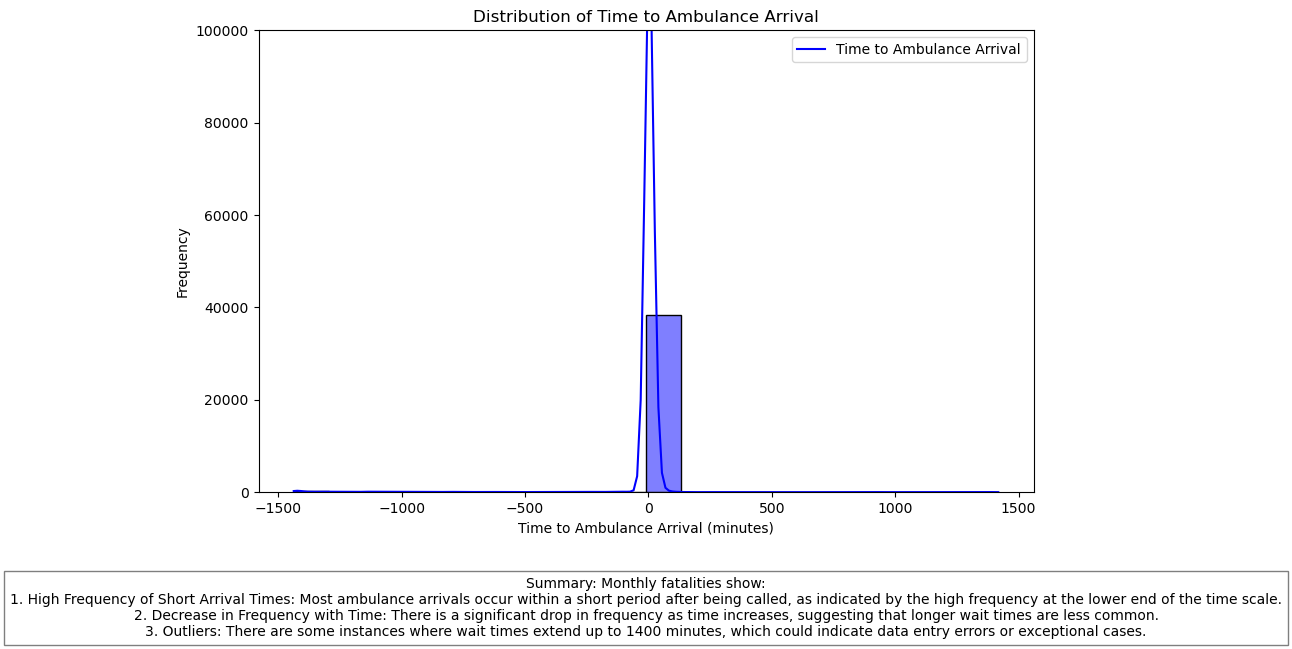

In [11]:
# Cap the frequency values at 100
max_frequency = 100000

# Response Time to Ambulance Arrival:
plt.figure(figsize=(10, 6))
sns.histplot(df['TIME_TO_AMBO'], bins=20, kde=True, color='blue')
plt.title('Distribution of Time to Ambulance Arrival')
plt.xlabel('Time to Ambulance Arrival (minutes)')
plt.ylabel('Frequency')
plt.legend(['Time to Ambulance Arrival'])
plt.ylim(0, max_frequency)  # Limit the frequency value to 100

# Add summary text box
summary_text = (
    "Summary: Monthly fatalities show:\n"
    "1. High Frequency of Short Arrival Times: Most ambulance arrivals occur within a short period after being called, "
    "as indicated by the high frequency at the lower end of the time scale.\n"
    "2. Decrease in Frequency with Time: There is a significant drop in frequency as time increases, suggesting that longer wait times are less common.\n"
    "3. Outliers: There are some instances where wait times extend up to 1400 minutes, which could indicate data entry errors or exceptional cases."
)
plt.text(0.5, -0.25, summary_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

## CREATE USA MAP VISUALIZATION

## CREATE CA ONLY VISUALIZATION

In [ ]:
# Create a new dataframe with only the required columns and filter for California
accident_geo_ca_df = df[['STATENAME', 'ST_CASE', 'FATALS', 'LATITUDE', 'LONGITUD']]
accident_geo_ca_df = accident_geo_ca_df[accident_geo_df['STATENAME'] == 'California']

# Display the first 5 rows of the DataFrame
accident_geo_ca_df

In [ ]:
# Load US states shapefile
shapefile_path = 'C:/Users/mmack/OneDrive/Desktop/Traffic_Collisions_Project4/Mary/shapefiles/ne_110m_admin_1_states_provinces.shp'

## USA MAP VISUALIZATION

In [ ]:
# Aggregate data by state
state_data = accident_geo_df.groupby('STATENAME').agg({
    'ST_CASE': 'count',
    'FATALS': 'sum'
}).reset_index()
state_data.columns = ['STATE', 'ACCIDENTS', 'FATALITIES']

# Convert STATE column to string
state_data['STATE'] = state_data['STATE'].astype(str)

# Load US states shapefile
shapefile_path = 'C:/Users/mmack/OneDrive/Desktop/Traffic_Collisions_Project4/Mary/shapefiles/ne_110m_admin_1_states_provinces.shp'
us_states = gpd.read_file(shapefile_path)

# Convert postal column to string
us_states['postal'] = us_states['postal'].astype(str)

# Merge state data with shapefile
us_states = us_states.merge(state_data, left_on='postal', right_on='STATE', how='left')

# Initialize a map centered around the United States
us_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add state polygons to the map with color scale based on fatalities
folium.Choropleth(
    geo_data=us_states,
    name='choropleth',
    data=us_states,
    columns=['STATE', 'FATALITIES'],
    key_on='feature.properties.postal',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Fatalities'
).add_to(us_map)

# Add popups with number of accidents and fatalities
for _, row in us_states.iterrows():
    folium.GeoJson(
        row['geometry'],
        tooltip=folium.Tooltip(f"State: {row['name']}<br>Accidents: {row['ACCIDENTS']}<br>Fatalities: {row['FATALITIES']}")
    ).add_to(us_map)

# Save the map to an HTML file
us_map.save('C:/Users/mmack/OneDrive/Desktop/Traffic_Collisions_Project4/Mary/us_accidents_map1.html')

## CREATE USA MAP TOTALS BY STATE POPUP

In [15]:
usa_map_df = df[['STATENAME', 'ST_CASE', 'FATALS']]
usa_map_df.head()

,STATENAME,ST_CASE,FATALS
0,Alabama,10001,1
1,Alabama,10002,2
2,Alabama,10003,1
3,Alabama,10004,1
4,Alabama,10005,1


In [16]:
# Count unique ST_CASE values grouped by STATENAME
accidents_count = usa_map_df.groupby('STATENAME')['ST_CASE'].nunique().reset_index()
accidents_count.columns = ['STATENAME', 'ACCIDENTS']

# Count number of fatalities grouped by STATENAME
fatalities_count = usa_map_df.groupby('STATENAME')['FATALS'].sum().reset_index()
fatalities_count.columns = ['STATENAME', 'FATALITIES']

# Merge the counts into a single dataframe
state_data = pd.merge(accidents_count, fatalities_count, on='STATENAME')

# Load US states shapefile
shapefile_path = 'C:/Users/mmack/OneDrive/Desktop/Traffic_Collisions_Project4/Mary/shapefiles/ne_110m_admin_1_states_provinces.shp'
us_states = gpd.read_file(shapefile_path)

# Merge state data with shapefile
us_states = us_states.merge(state_data, left_on='name', right_on='STATENAME', how='left')

# Initialize a map centered around the United States
us_map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add state polygons to the map with color scale based on fatalities
folium.Choropleth(
    geo_data=us_states,
    name='choropleth',
    data=us_states,
    columns=['STATENAME', 'FATALITIES'],
    key_on='feature.properties.name',
    fill_color='RdYlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Fatalities'
).add_to(us_map)

# Add popups with number of accidents and fatalities
for _, row in us_states.iterrows():
    folium.GeoJson(
        row['geometry'],
        tooltip=folium.Tooltip(f"State: {row['name']}<br>Accidents: {row['ACCIDENTS']}<br>Fatalities: {row['FATALITIES']}")
    ).add_to(us_map)

# Save the map to an HTML file
us_map.save('C:/Users/mmack/OneDrive/Desktop/Traffic_Collisions_Project4/Mary/us_accidents_map2.html')

NameError: name 'folium' is not defined

In [ ]:
# Filter out rows where any of the time columns have the value ":01"
filtered_df = cleaned_df[
    (cleaned_df['TIME_OCCUR'] != '12:01 AM') &
    (cleaned_df['TIME_REPORTED'] != '12:01 AM') &
    (cleaned_df['AMBO_ARR_TIME'] != '12:01 AM') &
    (cleaned_df['HOSP_ARR_TIME'] != '12:01 AM')
]

# Display the filtered dataframe to verify
filtered_df

In [ ]:
# Display basic information of the DataFrame
display(df.info())

In [ ]:
# # Use Selenium to take a screenshot of the map
# options = webdriver.ChromeOptions()
# options.add_argument('--headless')
# driver = 'C:/Users/mmack/.wdm/drivers/chromedriver/win64/127.0.6533.99/chromedrivermanager().install()'
# driver.get(f'file:///{us_accidents_map.png}')
# #time.sleep(5)  # Give the map some time to load

# # Save the screenshot
# screenshot_path = 'C:/Users/mmack/OneDrive/Desktop/Traffic_Collisions_Project4/Mary/us_accidents_map2.png'
# driver.save_screenshot(screenshot_path)
# driver.quit()

# print(f"Map saved as image at {screenshot_path}")